In [ ]:
# === Setup and Imports ===
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import tensorflow.keras.backend as K

# For Grad-CAM
from tensorflow.keras.preprocessing import image

# For LIME
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Set matplotlib to display inline
%matplotlib inline

# === (Optional) Disable Mixed Precision ===
# If you choose to disable mixed precision, uncomment the following lines:
# from tensorflow.keras.mixed_precision import set_global_policy
# set_global_policy('float32')

# Define Dice Coefficient (if not already included in saved models)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), dtype='float32')
    y_pred_f = K.cast(K.flatten(y_pred), dtype='float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )

# Import layers
from tensorflow.keras import layers

# === Define get_last_conv_layer Function ===
def get_last_conv_layer(model):
    """
    Retrieves the name of the last convolutional layer in a Keras model.
    Ensures that the returned layer name has no leading or trailing spaces.

    Parameters:
    - model: Trained Keras model.

    Returns:
    - last_conv_layer_name: Clean name of the last Conv2D or Conv2DTranspose layer.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, (layers.Conv2D, layers.Conv2DTranspose)):
            return layer.name.strip()  # Remove any accidental spaces
    raise ValueError("No convolutional layer found in the model.")

# === Mount Google Drive ===
drive.mount('/content/drive')

# === Load Test Data ===
# Define paths
base_dir = '/content/drive/MyDrive/health_care_project/extracted_files'
test_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_Data')
test_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_GroundTruth')

# Function to load images from a folder
def load_images_from_folder(folder, size=(128, 128), grayscale=False):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, size)  # Resize for consistency
            if not grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
    return np.array(images)

# Load test images and masks
test_images = load_images_from_folder(test_images_dir, size=(128, 128), grayscale=False)
test_masks = load_images_from_folder(test_masks_dir, size=(128, 128), grayscale=True)

# Preprocess data
test_images = test_images / 255.0
test_masks = test_masks / 255.0

if test_masks.ndim == 3:
    test_masks = np.expand_dims(test_masks, axis=3)

    # Cast to float32 to ensure consistency
test_images = test_images.astype('float32')
test_masks = test_masks.astype('float32')

print(f'Test Images Shape: {test_images.shape}')
print(f'Test Masks Shape: {test_masks.shape}')


# Define model paths
unet_plus_plus_path = '/content/drive/MyDrive/health_care_project/unet_plus_plus_model.keras'
unet_path = '/content/drive/MyDrive/health_care_project/unet_model.keras'
resunet_path = '/content/drive/MyDrive/health_care_project/resunet_model.keras'

# Custom objects (if any, e.g., dice_coef)
custom_objects = {'dice_coef': dice_coef, 'MeanIoU': MeanIoU}

# Load models
print("Loading U-Net++ model...")
unet_plus_plus_model = load_model(unet_plus_plus_path, custom_objects=custom_objects)

print("Loading U-Net model...")
unet_model = load_model(unet_path, custom_objects=custom_objects)

print("Loading ResUNet model...")
resunet_model = load_model(resunet_path, custom_objects=custom_objects)



# === Grad-CAM Functions ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.
    """
    # Create a model that maps the input image to the activations of the last conv layer and the model's output
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the mean of predictions w.r.t the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_mean(predictions)

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Cast conv_outputs and grads to float32
    conv_outputs = tf.cast(conv_outputs, tf.float32)
    grads = tf.cast(grads, tf.float32)

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

    # Average the gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(1, 2))

    # Compute the dot product of the weights and the conv outputs
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()

    # Process the heatmap
    heatmap = cam[0]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap

def superimpose_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Superimposes the heatmap on the original image.
    """
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    # Ensure img is in [0,1] float and convert to [0,255] uint8
    if img.dtype != np.uint8:
        img_uint8 = np.clip(img * 255.0, 0, 255).astype('uint8')
    else:
        img_uint8 = img

    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

    # Superimpose the heatmap on the image
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img_bgr, 1 - alpha, 0)

    # Convert back to RGB
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Ensure the final image is uint8
    superimposed_img = superimposed_img.astype('uint8')

    # Debug: Print data type
    print(f"superimposed_img dtype: {superimposed_img.dtype}")

    return superimposed_img

def apply_gradcam(model, img, last_conv_layer_name, preprocess_input=True):
    """
    Applies Grad-CAM to a single image for a given model.
    """
    if preprocess_input:
        img_array = np.expand_dims(img, axis=0)  # Add batch dimension
        img_array = tf.cast(img_array, tf.float32)  # Ensure float32
    else:
        img_array = img

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    superimposed_img = superimpose_heatmap(img, heatmap)

    return superimposed_img, heatmap

def visualize_gradcam(models, model_names, images, heatmap_layers, num_images=3):
    """
    Visualizes Grad-CAM heatmaps for multiple models on a set of images.
    """
    plt.figure(figsize=(15, num_images * 5))
    for i in range(num_images):
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]
        plt.subplot(num_images, len(models) + 1, i*(len(models)+1) + 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        for j, (model, model_name, heatmap_layer) in enumerate(zip(models, model_names, heatmap_layers)):
            superimposed_img, heatmap = apply_gradcam(model, img, heatmap_layer)

            # Debug: Check data type
            print(f"Superimposed Image dtype for {model_name}: {superimposed_img.dtype}")

            plt.subplot(num_images, len(models) + 1, i*(len(models)+1) + 2 + j)
            plt.imshow(superimposed_img)
            plt.title(f'Grad-CAM: {model_name}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b58a8125190c80341428c50de75c7a077119b5697a7ee0fa6f45580091784e58
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
Mounted at /content/drive
Test Images Shape: (379, 128, 128, 3)
Test Masks Shape: (379, 128, 128, 1)
Loading U-Net++ model...


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 74 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loading U-Net model...
Loading ResUNet model...


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 158 variables whereas the saved optimizer has 162 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NameError: name 'models' is not defined

Last Conv Layer - U-Net++: 'conv2d_51'
Last Conv Layer - U-Net: 'conv2d_36'
Last Conv Layer - ResUNet: 'conv2d_21'
Layer 'conv2d_51' found in U-Net++.
Layer 'conv2d_36' found in U-Net.
Layer 'conv2d_21' found in ResUNet.
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net++: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for ResUNet: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net++: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for ResUNet: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net++: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for ResUNet: uint8


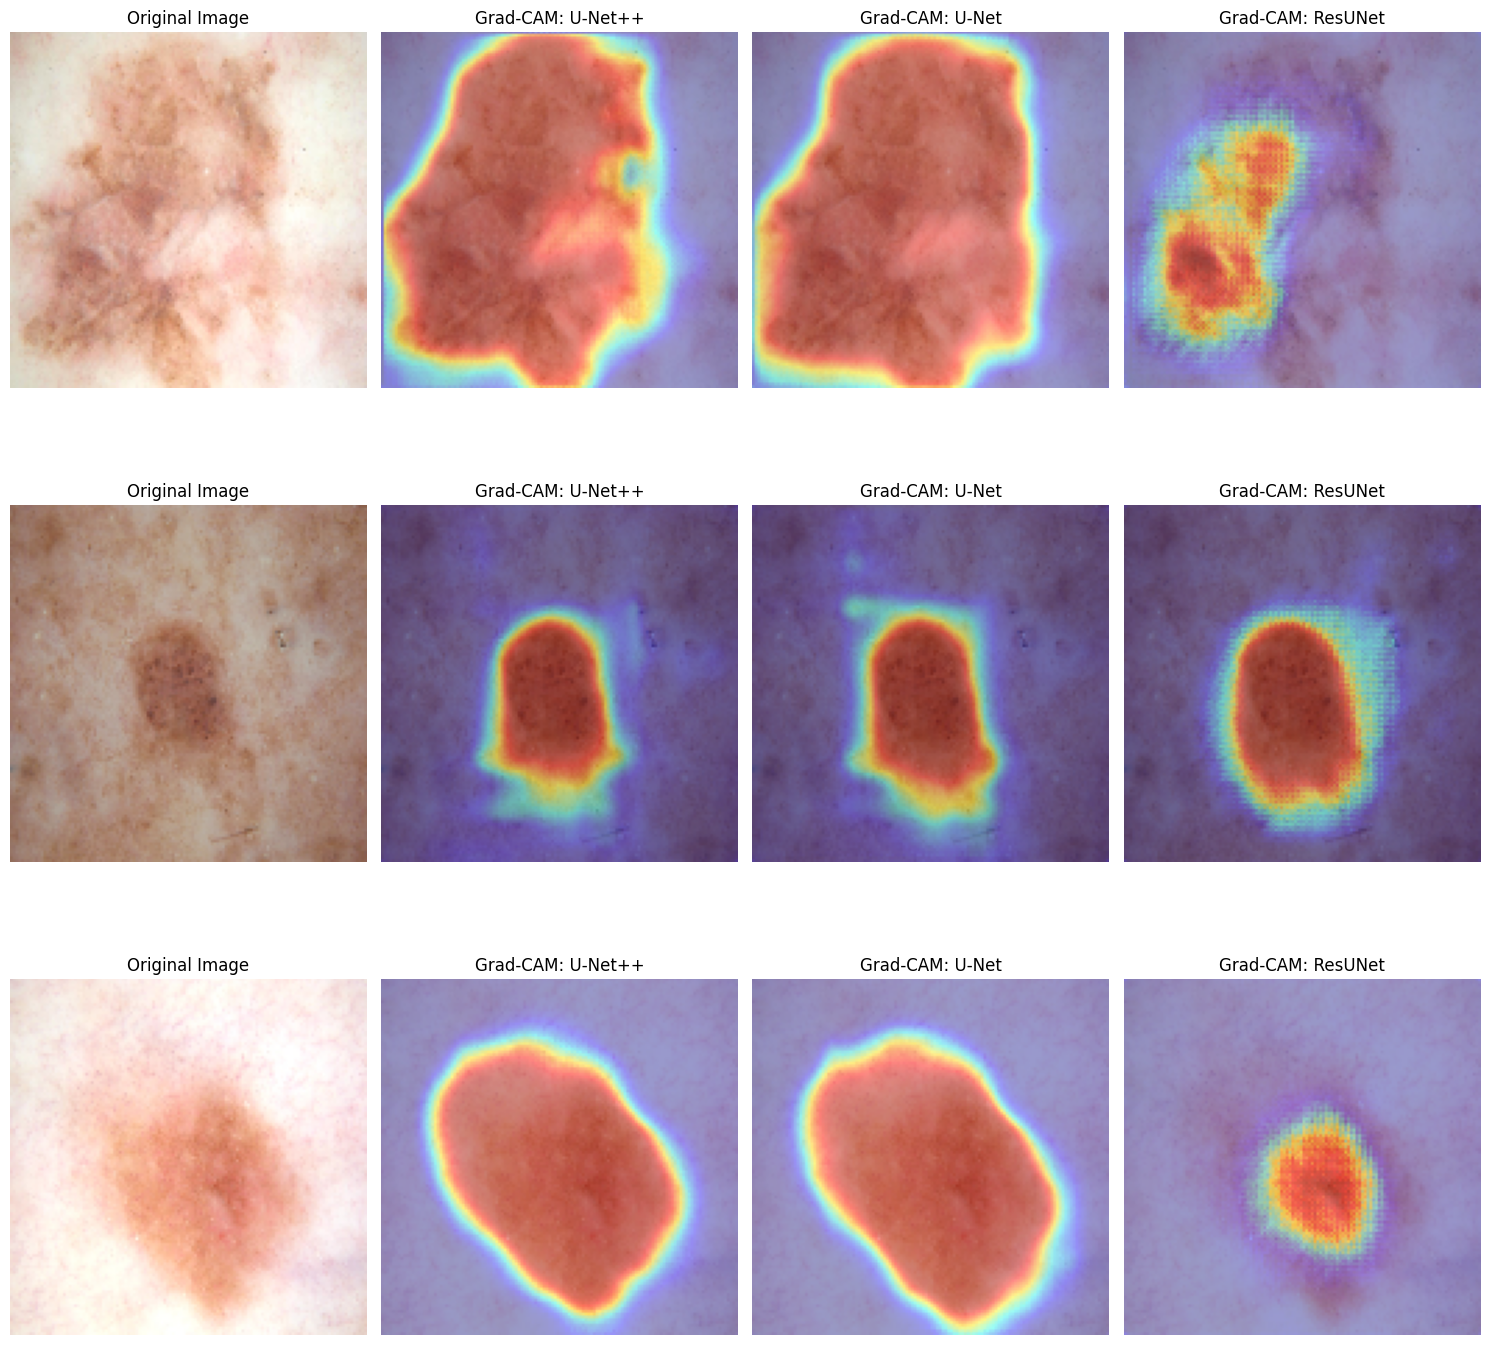

In [ ]:
# Retrieve and verify last convolutional layers
last_conv_layer_unetpp = get_last_conv_layer(unet_plus_plus_model)
last_conv_layer_unet = get_last_conv_layer(unet_model)
last_conv_layer_resunet = get_last_conv_layer(resunet_model)

print(f"Last Conv Layer - U-Net++: '{last_conv_layer_unetpp}'")
print(f"Last Conv Layer - U-Net: '{last_conv_layer_unet}'")
print(f"Last Conv Layer - ResUNet: '{last_conv_layer_resunet}'")

# Define models and heatmap layers
models = [unet_plus_plus_model, unet_model, resunet_model]
model_names = ["U-Net++", "U-Net", "ResUNet"]
heatmap_layers = [last_conv_layer_unetpp, last_conv_layer_unet, last_conv_layer_resunet]

# Verify layer existence
for model, layer_name, model_name in zip(models, heatmap_layers, model_names):
    try:
        layer = model.get_layer(layer_name)
        print(f"Layer '{layer_name}' found in {model_name}.")
    except ValueError:
        print(f"Layer '{layer_name}' NOT found in {model_name}.")


   # Visualize Grad-CAM
visualize_gradcam(models, model_names, test_images, heatmap_layers, num_images=3)

In [ ]:
# === Setup and Imports ===
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import tensorflow.keras.backend as K

# For Grad-CAM
from tensorflow.keras.preprocessing import image

# For LIME
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Set matplotlib to display inline
%matplotlib inline

# === Disable Mixed Precision ===
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('float32')

# Define Dice Coefficient (if not already included in saved models)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), dtype='float32')
    y_pred_f = K.cast(K.flatten(y_pred), dtype='float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )

# Import layers
from tensorflow.keras import layers

# === Define get_last_conv_layer Function ===
def get_last_conv_layer(model):
    """
    Retrieves the name of the last convolutional layer in a Keras model.
    Ensures that the returned layer name has no leading or trailing spaces.

    Parameters:
    - model: Trained Keras model.

    Returns:
    - last_conv_layer_name: Clean name of the last Conv2D or Conv2DTranspose layer.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, (layers.Conv2D, layers.Conv2DTranspose)):
            return layer.name.strip()  # Remove any accidental spaces
    raise ValueError("No convolutional layer found in the model.")

# === Mount Google Drive ===
drive.mount('/content/drive')

# === Load Test Data ===
# Define paths
base_dir = '/content/drive/MyDrive/health_care_project/extracted_files'
test_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_Data')
test_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_GroundTruth')

# Function to load images from a folder
def load_images_from_folder(folder, size=(128, 128), grayscale=False):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, size)  # Resize for consistency
            if not grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
    return np.array(images)

# Load test images and masks
test_images = load_images_from_folder(test_images_dir, size=(128, 128), grayscale=False)
test_masks = load_images_from_folder(test_masks_dir, size=(128, 128), grayscale=True)

# Preprocess data
test_images = test_images / 255.0
test_masks = test_masks / 255.0

if test_masks.ndim == 3:
    test_masks = np.expand_dims(test_masks, axis=3)  # Add the channel dimension

print(f'Test Images Shape: {test_images.shape}')
print(f'Test Masks Shape: {test_masks.shape}')



# === Retrieve Last Convolutional Layers ===
last_conv_layer_unetpp = get_last_conv_layer(unet_plus_plus_model)
last_conv_layer_unet = get_last_conv_layer(unet_model)
last_conv_layer_resunet = get_last_conv_layer(resunet_model)

print(f"Last Conv Layer - U-Net++: '{last_conv_layer_unetpp}'")
print(f"Last Conv Layer - U-Net: '{last_conv_layer_unet}'")
print(f"Last Conv Layer - ResUNet: '{last_conv_layer_resunet}'")

# === Define Models and Heatmap Layers Lists ===
models = [unet_plus_plus_model, unet_model, resunet_model]
model_names = ["U-Net++", "U-Net", "ResUNet"]
heatmap_layers = [last_conv_layer_unetpp, last_conv_layer_unet, last_conv_layer_resunet]

# === Verify Layer Existence ===
for model, layer_name, model_name in zip(models, heatmap_layers, model_names):
    try:
        layer = model.get_layer(layer_name)
        print(f"Layer '{layer_name}' found in {model_name}.")
    except ValueError:
        print(f"Layer '{layer_name}' NOT found in {model_name}.")

# === Grad-CAM Functions ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.
    """
    # Create a model that maps the input image to the activations of the last conv layer
    # and the model's output
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the mean of predictions w.r.t the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_mean(predictions)

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Cast conv_outputs and grads to float32
    conv_outputs = tf.cast(conv_outputs, tf.float32)
    grads = tf.cast(grads, tf.float32)

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

    # Average the gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(1, 2))

    # Compute the dot product of the weights and the conv outputs
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()

    # Process the heatmap
    heatmap = cam[0]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap

def superimpose_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Superimposes the heatmap on the original image.
    """
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Superimpose the heatmap on the image
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img_bgr, 1 - alpha, 0)

    # Convert back to RGB
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img

def apply_gradcam(model, img, last_conv_layer_name, preprocess_input=True):
    """
    Applies Grad-CAM to a single image for a given model.
    """
    if preprocess_input:
        img_array = np.expand_dims(img, axis=0)  # Add batch dimension
        img_array = tf.cast(img_array, tf.float32)  # Ensure float32
    else:
        img_array = img

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    superimposed_img = superimpose_heatmap(img, heatmap)

    return superimposed_img, heatmap

def visualize_gradcam(models, model_names, images, heatmap_layers, num_images=3):
    """
    Visualizes Grad-CAM heatmaps for multiple models on a set of images.
    """
    plt.figure(figsize=(15, num_images * 5))
    for i in range(num_images):
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]
        plt.subplot(num_images, len(models) + 1, i*(len(models)+1) + 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        for j, (model, model_name, heatmap_layer) in enumerate(zip(models, model_names, heatmap_layers)):
            superimposed_img, heatmap = apply_gradcam(model, img, heatmap_layer)
            plt.subplot(num_images, len(models) + 1, i*(len(models)+1) + 2 + j)
            plt.imshow(superimposed_img)
            plt.title(f'Grad-CAM: {model_name}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()


Evaluating U-Net++...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Completed evaluation for U-Net++.

Evaluating U-Net...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Completed evaluation for U-Net.

Evaluating ResUNet...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Completed evaluation for ResUNet.

╒════╤═════════╤════════════════════╤═════════════════╤══════════════════╤═════════════════╤══════════════════════╕
│    │ Model   │ Dice Coefficient   │ IoU Score       │ Pixel Accuracy   │ Mean IoU        │ Hausdorff Distance   │
╞════╪═════════╪════════════════════╪═════════════════╪══════════════════╪═════════════════╪══════════════════════╡
│  0 │ U-Net++ │ 0.8806 ± 0.1316    │ 0.8052 ± 0.1595 │ 0.9404 ± 0.0832  │ 0.8533 ± 0.1302 │ inf ± nan            │
├────┼─────────┼────────────────────┼─────────────────┼──────────────────┼─────────────────┼──────────────────────┤
│  1 │ U-Net   │ 0.8832 ± 0.1320    │ 0.8092 ± 0.1580 │ 0.9431 ± 0.0763  │ 0.8563 ± 0.1243 │ inf ± nan            │
├────┼─────────┼────────────────────┼─────────────────┼──────────────────┼─────────────────┼──────────────────────┤
│  2 │ ResUNet │ 0.7114 ± 0.2662    │ 0.6056 ± 0.2626 │ 0.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


ValueError: could not convert string to float: '0.8806 ± 0.1316'

<Figure size 1200x600 with 0 Axes>

superimposed_img dtype: uint8
Superimposed Image dtype for U-Net++: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for ResUNet: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net++: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for ResUNet: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net++: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for U-Net: uint8
superimposed_img dtype: uint8
Superimposed Image dtype for ResUNet: uint8


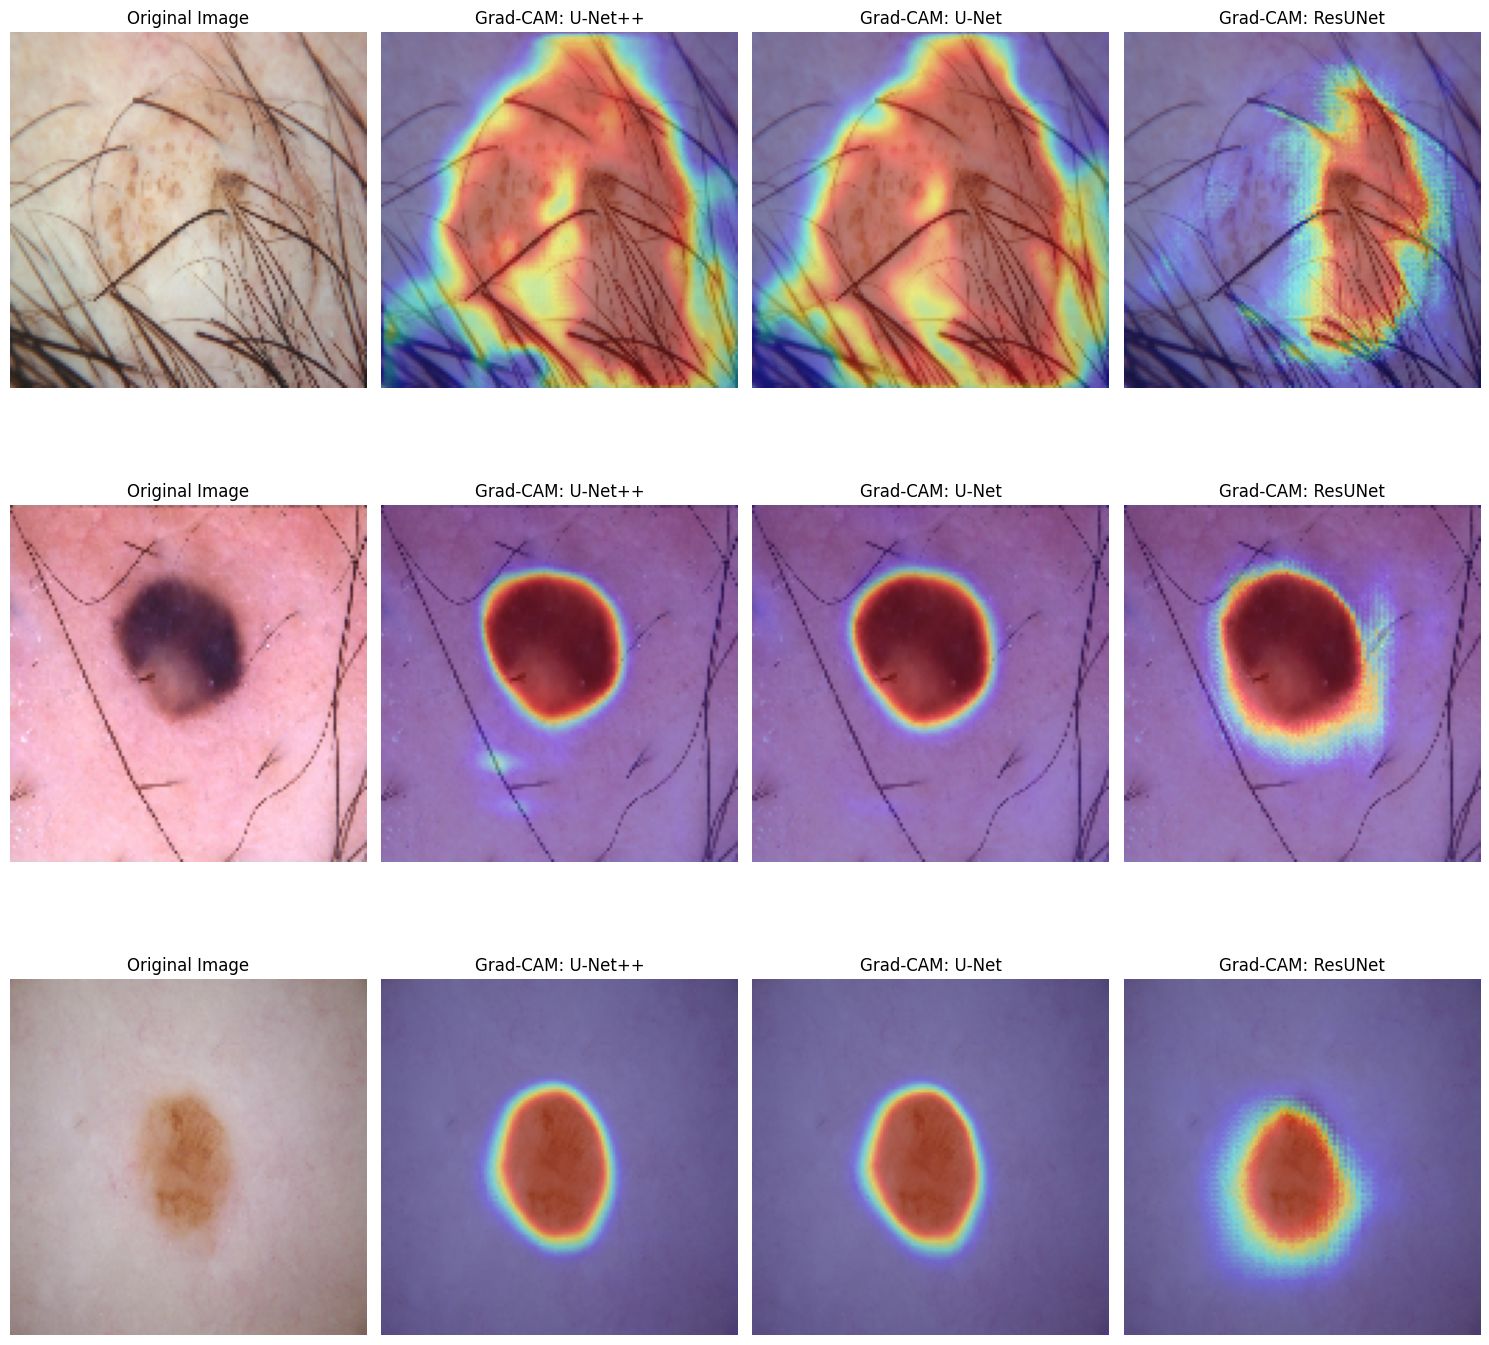

In [ ]:
# Visualize Grad-CAM
visualize_gradcam(models, model_names, test_images, heatmap_layers, num_images=3)
